In [1]:
#import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
#Tqdm is a Python library that provides fast, extensible progress bars for loops and iterables. 
#It's a simple way to track the advancement of time-intensive tasks. 

In [2]:
#Loading the data and variable declaring
# for the dataset, we will first declare some global variables
batch_size = 16
epoch_count = 2
noise_dim = 100 
n_class = 10
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
img_size = 32

# Load the dataset
(X_train, y_train), (_, _) = cifar10.load_data()

# Normalize the data
X_train = (X_train - 127.5) / 127.5

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 74s 0us/step


In [4]:
X_train

array([[[[-0.5372549 , -0.51372549, -0.50588235],
         [-0.6627451 , -0.63921569, -0.64705882],
         [-0.60784314, -0.62352941, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215686, -0.01960784, -0.2       ],
         [ 0.16078431, -0.02745098, -0.19215686]],

        [[-0.8745098 , -0.84313725, -0.84313725],
         [-1.        , -1.        , -1.        ],
         [-0.85882353, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980392, -0.56862745],
         [-0.06666667, -0.34901961, -0.60784314],
         [-0.04313725, -0.31764706, -0.55294118]],

        [[-0.80392157, -0.81176471, -0.83529412],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.61568627, -0.78823529, -0.9372549 ],
         ...,
         [-0.0745098 , -0.34117647, -0.60784314],
         [-0.05882353, -0.34117647, -0.60784314],
         [-0.14509804, -0.42745098, -0.67058824]],

        ...,

        [[ 0.63137255,  0.33333333, -0

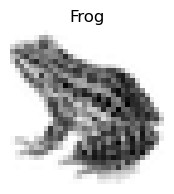

In [8]:
#Visua# plotting a random image from the dataset
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()


In [ ]:
#Defining Loss function and Optimizers

# In the next step, we need to define the Loss function and optimizer for the discriminator and generator networks in a Conditional Generative Adversarial Network(CGANS).

Binary Cross-Entropy Loss (bce loss) is suitable for distinguishing between real and fake data in GANs.
The discriminator loss function take two arguments, real and fake.
The binary entropy calculates two losses:
real_loss: the loss when the discriminator tries to classify real data as real
fake_loss : the loss when the discriminator tries to classify fake data as fake
The total loss is the sum of real_loss and fake_loss which represents how well the discriminator is at distinguishing between real and fake data
The generator_loss function calculates the bce loss for the generator. The aim of the generator is discriminate real and fake data.
d_optimizer and g_optimizer are used to update the trainable parameters of the discriminator and generator during training. Adam optimizer is employed to update the trainable parameters.

In [9]:
# Define Loss function for Classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss
  
# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds)
  
 # Optimiser for both Generator and Dsicriminator 
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [ ]:
#Building the Generator Model

# Now, let us begin with building the generator model. The generator takes a label and noise as input and generates data based on the label. Since we are giving a condition, i.e., our label, we will use an embedding layer to change each label into a vector representation of size 50. And after building the model, we will check the architecture of the model.

the input layer is used to provide the label as input to the generators
the embedding layer converts the label (i.e., single value) into vector representation of size 50
the input layer is used to provide the noise (latent space input) to the generator. The latent space input goes through a series of dense layers with large number of nodes and LeakyRelu activation function.
the label are reshaped and the concatenated with the processed latent space.
the merged data goes to a series of convolution transpose layers:
the first 'Conv2DTranspose' layer doubles the spatial size to ' 16x16x128' and LeakyReLU activation is applied.
the second 'Conv2DTranspose' layer double the spatial size to '32x32x128', and LeakyReLU activation is applied.
The final output layer convolutional layer with 3 channels (for RGB color), using a kernel size (8,8) and activation function 'tanh'. it produces an image with size '32x32x3' as the desired

In [10]:
def build_generator():

  # label input
    in_label = tf.keras.layers.Input(shape=(1,))

    # create an embedding layer for all the 10 classes in the form of a vector 
    # of size 50
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)

    n_nodes = 8 * 8
    li = tf.keras.layers.Dense(n_nodes)(li)
    # reshape the layer
    li = tf.keras.layers.Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = tf.keras.layers.Input(shape=(noise_dim,))

    n_nodes = 128 * 8 * 8
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

    # merge image gen and label input
    merge = tf.keras.layers.Concatenate()([gen, li])

    gen = tf.keras.layers.Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same')(merge)  # 16x16x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    gen = tf.keras.layers.Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same')(gen)  # 32x32x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    out_layer = tf.keras.layers.Conv2D(
        3, (8, 8), activation='tanh', padding='same')(gen)  # 32x32x3

    model = Model([in_lat, in_label], out_layer)
    return model


g_model = build_generator()
g_model.summary()

C:\Users\Mohan\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 8192)              │         827,392 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 50)             │             500 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 8192)              │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1, 64)             │           3,264 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 8, 8, 128)         │               0 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 8, 8, 1)           │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 8, 8, 129)         │               0 │ reshape_1[0][0],           │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 16, 16, 128)       │         264,320 │ concatenate[0][0]          │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 16, 16, 128)       │               0 │ conv2d_transpose[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 32, 32, 128)       │         262,272 │ leaky_re_lu_1[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 32, 32, 128)       │               0 │ conv2d_transpose_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 3)         │          24,579 │ leaky_re_lu_2[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

Now we will create a train step function for training our GAN model together using Gradient Tape. Gradient Tape allows use to use custom loss functions, update weights or not and also helps in training faster.

The code provided below defines a complete training step for a GAN, where the generator and discriminator are updated alternately.

The tf.function makes sure the training step can be executed efficiently in a TensorFlow graph.

In [14]:
## Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):
   
    real_images, real_labels = dataset
    # Sample random points in the latent space and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model([random_latent_vectors, real_labels])

    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        
        d_loss = discriminator_loss(pred_real, pred_fake)
      
    grads = tape.gradient(d_loss, d_model.trainable_variables)
    # print(grads)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    #-----------------------------------------------------------------#
    
    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
   
    # Train the generator
    with tf.GradientTape() as tape:
        fake_images = g_model([random_latent_vectors, real_labels])
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)
    
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    
    return d_loss, g_loss

# Also we will create a helper code for visualizing the output after each epoch ends for each class. The examples of images generated for each class. demonstrating how well the generator can produce images conditioned on specific labels or classes.

In [15]:
# Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20)) 
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

In [16]:
#Training the model and Visualize the output
def train(dataset, epochs=epoch_count):

    for epoch in range(epochs):
        print('Epoch: ', epochs)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()
        
        itern = 0
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1
                
        show_samples(3, n_class, g_model)
            
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')
        
 
train(dataset, epochs=epoch_count)

Epoch:  2


  0%|                                                                                         | 0/3125 [00:00<?, ?it/s]


NameError: in user code:

    File "C:\Users\Mohan\AppData\Local\Temp\ipykernel_5308\357843362.py", line 12, in train_step  *
        pred_fake = d_model([generated_images, real_labels])

    NameError: name 'd_model' is not defined
